# Explainable AI

__Source__: What is explainable AI? https://www.ibm.com/think/topics/explainable-ai

What is explainable AI?

Explainable artificial intelligence (XAI) is a set of processes and methods that allows human users to comprehend and trust the results and output created by machine learning algorithms.

- It helps characterize model accuracy, fairness, transparency and outcomes in AI-powered decision making.

  
- It is crucial for an organization in building trust and confidence when putting AI models into production

### Explainable AI techniques

The setup of XAI techniques consists of three main methods. 

__Prediction accuracy__ and __traceability__ address technology requirements while __decision understanding__ addresses human needs.

#### Prediction accuracy

Running simulations and comparing XAI output to the results in the training data set, the prediction accuracy can be determined. 


Local Interpretable Model-Agnostic Explanations (LIME) 

    - It tests what happens to the predictions when you give variations of your data into the machine learning model. 

SHAP (SHapley Additive exPlanations) 

    - It is a game theoretic approach to explain the output of any machine learning model.
    
    - It reflects the significance of the contribution of features for each output prediction.



#### Traceability

- DeepLIFT (Deep Learning Important FeaTures), which compares the activation of each neuron to its reference neuron and shows a traceable link between each activated neuron and even shows dependencies between them.

- Gradient-weighted Class Activation Map (Gradcam), used to generate heatmaps which highlights the important region of the image that contribute the way a model performs as it does. 

## Experiments on Synthetic Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import pandas as pd
import torch.utils.data as Data
from torchinfo import summary

from torch.nn import functional as F

from torch.nn.functional import softmax, interpolate
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:
def makeImages(nEach):
    images = np.zeros((nEach * 2, 1, 20, 20))  # nSamples, nChannels, rows, columns
    radii = 3 + np.random.randint(10 - 5, size=(nEach * 2, 1))
    centers = np.zeros((nEach * 2, 2))
    for i in range(nEach * 2):
        r = radii[i, 0]
        centers[i, :] = r + 1 + np.random.randint(18 - 2 * r, size=(1, 2))
        x = int(centers[i, 0])
        y = int(centers[i, 1])
        if i < nEach:
            # squares
            images[i, 0, x - r:x + r, y + r] = 1.0
            images[i, 0, x - r:x + r, y - r] = 1.0
            images[i, 0, x - r, y - r:y + r] = 1.0
            images[i, 0, x + r, y - r:y + r + 1] = 1.0
        else:
            # diamonds
            images[i, 0, range(x - r, x), range(y, y + r)] = 1.0
            images[i, 0, range(x - r, x), range(y, y - r, -1)] = 1.0
            images[i, 0, range(x, x + r + 1), range(y + r, y - 1, -1)] = 1.0
            images[i, 0, range(x, x + r), range(y - r, y)] = 1.0

        T = np.zeros((nEach * 2, 1))
        T[nEach:] = 1
    return images, T

In [5]:
nEach = 1000
X, T = makeImages(nEach)
X = X.reshape(X.shape[0], -1)
print(X.shape, T.shape)

Xtest, Ttest = makeImages(nEach)
Xtest = Xtest.reshape(Xtest.shape[0], -1)

(2000, 400) (2000, 1)


[0. 1.]


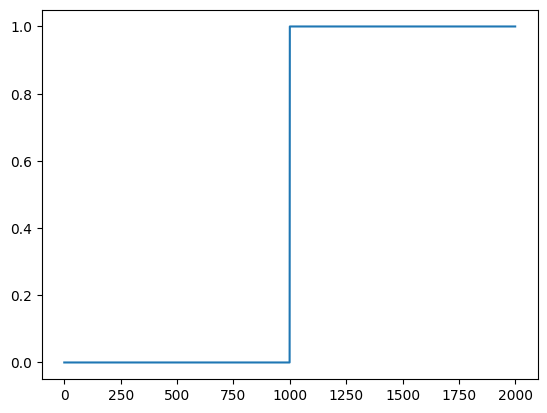

In [6]:
print(np.unique(T))
plt.plot(T);

([], [])

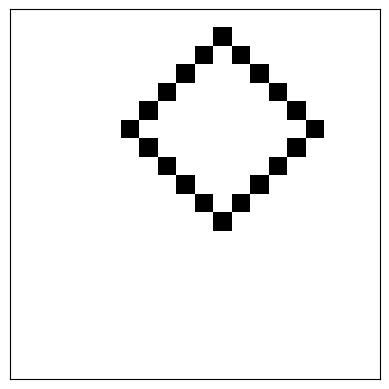

In [7]:
plt.imshow(-X[-1, :].reshape(20, 20), cmap='gray')
plt.xticks([])
plt.yticks([])

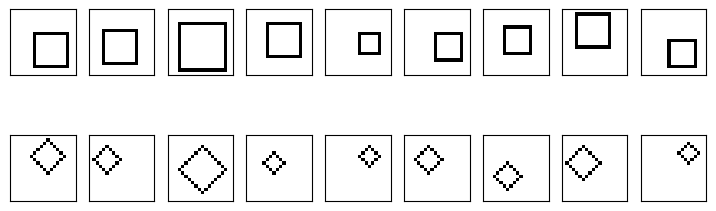

In [8]:
plt.figure(figsize=(10, 3))

for i in range(1,10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(-X[i-1, :].reshape(20,20), cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 10, i + 11)
    plt.imshow(-X[-i, :].reshape(20,20), cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [9]:
class DData(Data.Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    
    def __getitem__(self, i):
        return self.X[i, :], self.y[i]

    def __len__(self):
        return len(self.X)

In [10]:
Xtrain = DData(X,T)
Xtest = DData(Xtest,Ttest)

In [11]:
class myClassifier(nn.Module):
    def __init__(self, n_features, hiddenA, hiddenB):
        super(myClassifier, self).__init__()
        self.fc1 = nn.Linear(n_features, hiddenA)
        self.fc2 = nn.Linear(hiddenA, hiddenB)
        self.output = nn.Linear(hiddenB, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.sigmoid(self.output(x))

In [12]:
model = myClassifier(X.shape[1], 25, 5)

In [13]:
model.fc1

Linear(in_features=400, out_features=25, bias=True)

In [14]:
model.fc1.weight.shape

torch.Size([25, 400])

In [15]:
model.fc1.bias.shape

torch.Size([25])

In [16]:
summary(model)

Layer (type:depth-idx)                   Param #
myClassifier                             --
├─Linear: 1-1                            10,025
├─Linear: 1-2                            130
├─Linear: 1-3                            6
├─Sigmoid: 1-4                           --
Total params: 10,161
Trainable params: 10,161
Non-trainable params: 0

In [17]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0088, -0.0095,  0.0335,  ..., -0.0448, -0.0061,  0.0168],
         [-0.0380,  0.0363,  0.0421,  ..., -0.0238,  0.0288, -0.0121],
         [ 0.0274, -0.0084, -0.0401,  ..., -0.0136,  0.0392,  0.0495],
         ...,
         [ 0.0417, -0.0326,  0.0191,  ...,  0.0279, -0.0442, -0.0261],
         [ 0.0083, -0.0386,  0.0381,  ..., -0.0088, -0.0063, -0.0253],
         [ 0.0053,  0.0157, -0.0424,  ...,  0.0314,  0.0206, -0.0184]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0022,  0.0350, -0.0111,  0.0455, -0.0142,  0.0489,  0.0237,  0.0405,
         -0.0254, -0.0337,  0.0119,  0.0447,  0.0037, -0.0085, -0.0120, -0.0031,
          0.0282, -0.0371,  0.0309,  0.0100, -0.0264, -0.0230,  0.0141, -0.0327,
         -0.0362], requires_grad=True),
 Parameter containing:
 tensor([[-0.0331,  0.1741, -0.1491,  0.0021, -0.0993,  0.1211, -0.1064,  0.0983,
           0.0708, -0.1839,  0.1534,  0.1646,  0.1922,  0.1905, -0.0321, -0.0878,
           0.0

In [18]:
batch_size = 1
train_loader = Data.DataLoader(Xtrain, batch_size=batch_size, shuffle=True, num_workers= 0)
test_loader = Data.DataLoader(Xtest, batch_size=batch_size, shuffle=True, num_workers= 0)

In [19]:
'''
activation = {}
gradients = {}

def forward_hook(module, inpt, outpt):
    global activation
    activation[module] = outpt

def grad_hook(module, inpt, outpt):
    global gradients
    gradients[module] = outpt

def get_all_layers(model):
    for name, layer in model._modules.items():
        if isinstance(layer, nn.Sequential):
            get_all_layers(layer)
        else:
            # non sequential
            layer.register_forward_hook(forward_hook)
            layer.register_full_backward_hook(grad_hook)
'''

'\nactivation = {}\ngradients = {}\n\ndef forward_hook(module, inpt, outpt):\n    global activation\n    activation[module] = outpt\n\ndef grad_hook(module, inpt, outpt):\n    global gradients\n    gradients[module] = outpt\n\ndef get_all_layers(model):\n    for name, layer in model._modules.items():\n        if isinstance(layer, nn.Sequential):\n            get_all_layers(layer)\n        else:\n            # non sequential\n            layer.register_forward_hook(forward_hook)\n            layer.register_full_backward_hook(grad_hook)\n'

In [20]:
#get_all_layers(model)

In [21]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [22]:
n_epochs = 15
all_losses = []
model.train(True)
for epoch in range(n_epochs):
    losses = []
    total = 0
    for x, y in train_loader:
        
        optimizer.zero_grad()
        
        y_pred = model(x)
        loss = loss_function(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        total += 1

    epoch_loss = sum(losses) / total
    all_losses.append(epoch_loss)
                
    mess = f"Epoch {epoch+1} \t Loss: {all_losses[-1]:.5f}"
    print(mess)

Epoch 1 	 Loss: 0.58496
Epoch 2 	 Loss: 0.34838
Epoch 3 	 Loss: 0.17018
Epoch 4 	 Loss: 0.06889
Epoch 5 	 Loss: 0.02663
Epoch 6 	 Loss: 0.01054
Epoch 7 	 Loss: 0.00431
Epoch 8 	 Loss: 0.00183
Epoch 9 	 Loss: 0.00080
Epoch 10 	 Loss: 0.00035
Epoch 11 	 Loss: 0.00016
Epoch 12 	 Loss: 0.00007
Epoch 13 	 Loss: 0.00003
Epoch 14 	 Loss: 0.00001
Epoch 15 	 Loss: 0.00001


In [23]:
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_pred.extend(model(x).numpy().round())
        y_true.extend(y.numpy())

In [24]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.1f} %')

Accuracy: 1.0 %


In [25]:
'''
model.train()
y_pred = model(torch.from_numpy(X[3, :].astype(np.float32)))
#optimizer.zero_grad()
loss = loss_function(y_pred, y[0])
loss.backward()
'''

'\nmodel.train(True)\ny_pred = model(torch.from_numpy(X[3, :].astype(np.float32)))\n#optimizer.zero_grad()\n#loss = loss_function(y_pred, y[0])\n#loss.backward()\n#optimizer.step()\ny_pred.backward(retain_graph=True)\n'

In [26]:
model.fc1

Linear(in_features=400, out_features=25, bias=True)

In [27]:
(model.fc1.weight.data).shape

torch.Size([25, 400])

In [28]:
act = model.fc1.weight.data
model.fc1.weight.data

tensor([[-0.0088, -0.0095,  0.0335,  ..., -0.0448, -0.0061,  0.0168],
        [-0.0380,  0.0363,  0.0421,  ..., -0.0238,  0.0288, -0.0121],
        [ 0.0274, -0.0084, -0.0401,  ..., -0.0136,  0.0392,  0.0495],
        ...,
        [ 0.0417, -0.0326,  0.0191,  ...,  0.0279, -0.0442, -0.0261],
        [ 0.0083, -0.0386,  0.0381,  ..., -0.0088, -0.0063, -0.0253],
        [ 0.0053,  0.0157, -0.0424,  ...,  0.0314,  0.0206, -0.0184]])

In [29]:
grad = model.fc1.weight.grad.data
model.fc1.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

([], [])

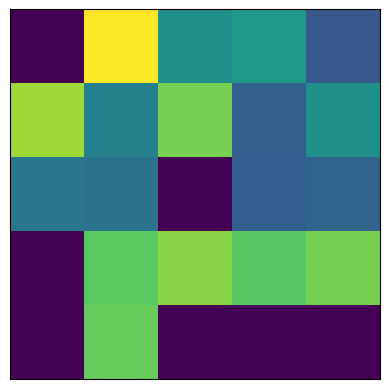

In [30]:
# weight the activation by corresponding gradients
#print(torch.mean(grad,1).shape)
#ggg

mact = torch.mean(act,1)
mgrad = torch.mean(grad,1)

mact *= mgrad

# relu on top of the heatmap
heatmap = F.relu(mact)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.imshow(heatmap.reshape(5,5).detach().numpy())
plt.xticks([])
plt.yticks([])

In [31]:
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import PIL

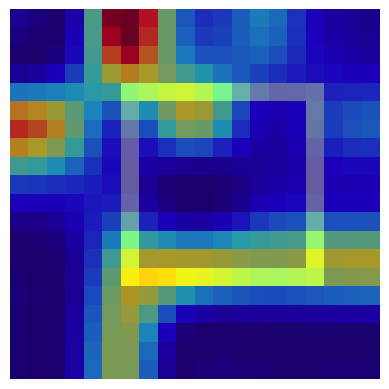

In [32]:
fig, ax = plt.subplots()
ax.axis('off') # removes the axis markers

# First plot the original image
ax.imshow(to_pil_image(-X[1999, :].reshape(20,20), mode='L'))
overlay = to_pil_image(heatmap.reshape(5,5), mode='F').resize((20,20), resample=PIL.Image.BICUBIC)

cmap = colormaps['jet']
overlay = (255 * cmap(np.asarray(overlay) ** 2)).astype(np.uint8)

ax.imshow(overlay, alpha=0.6, interpolation='nearest')

plt.show()